In [1]:
import os
import glob
import sys
import re
import gc

import numpy as np
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import geosketch
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import squidpy as sq

c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\anndata\utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [2]:
import torch
from lightning.pytorch import seed_everything

In [3]:
import scvi

c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\docrep\decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\docrep\decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


In [4]:
import cell2location
from cell2location.models import RegressionModel
from cell2location.utils.filtering import filter_genes

In [5]:
seed_everything(0)
torch.cuda.is_available()
torch.set_float32_matmul_precision('high')

Seed set to 0


In [6]:
results_folder = '../../data/visium/cell2location'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

The default parameters cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12 are a good starting point, however, you can increase the cut-off to exclude more genes. To preserve marker genes of rare cell types we recommend low cell_count_cutoff=5, however, cell_percentage_cutoff2 and nonz_mean_cutoff can be increased to select between 8k-16k genes.

In this 2D histogram, orange rectangle highlights genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis).

In [14]:
scrna = sc.read_h5ad("../../data/scrna/seurat_objects/normal_skin.scrna.harmony.integrated.reclustered.annotated.genes_filtered.tangram_input.h5ad")
scrna.X = scrna.layers['counts']

In [15]:
scrna

AnnData object with n_obs × n_vars = 273178 × 14762
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'pct.mito', 'pct.ribo', 'pct.hemo', 'study_id', 'sample_barcode', 'donor_id', 'donor_sex', 'donor_age', 'anatomic_site', 'reported.cell_type', 'anatomic_site.detailed', 'harmony.snn_res.0.2', 'harmony.snn_res.0.4', 'harmony.snn_res.0.5', 'harmony.snn_res.0.6', 'harmony.snn_res.0.8', 'harmony.snn_res.1', 'harmony.snn_res.1.2', 'harmony.snn_res.1.5', 'harmony.snn_res.2', 'harmony.snn_res.2.5', 'seurat_clusters', 'cell_barcode', 'cell_type.broad', 'cell_category', 'cell_type', 'cell_type.broad.res_0.2', 'cell_type.detailed', 'cell_type.reclustered', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_counts'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_varia

In [16]:
gc.collect()

2783

In [17]:
scrna.obs['cell_type.detailed'].astype(str).value_counts().sort_index()

cell_type.detailed
Bas Inf             5398
Bas KC             35398
Bulge               3801
CCR7+ DC             493
CD1C+ DC            8871
CD4+ Th            19313
CD4+ Treg           5738
CD8+ Tc            16368
CLEC9A+ DC          1459
Cyc Imm              518
Cyc KC             13326
DP                  1229
DS                  3022
Diff Inf            4834
Ecc Duct            1995
Ecc Gland           1365
Grn KC              3520
HEC                 9283
IRS/HS               227
LC                  2116
LEC                 4023
Mac                 9717
Mast                1422
Melano             10967
Mono                3027
Naïve T             3299
ORS Basal            566
ORS Suprabasal      1576
Papil Fib           3061
Peri               11820
Perivasc Fib I      2146
Perivasc Fib II     6166
Plasma               976
Retic Fib I        15288
Retic Fib II         369
Retic Fib III        465
SM                   367
Schwann              218
Spn KC I           47671
Spn KC

The signatures are estimated from scRNA-seq data, accounting for batch effect, using a Negative binomial regression model.

First, prepare anndata object for the regression model:

In [18]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=scrna, batch_key='donor_id', labels_key='cell_type.detailed')

In [19]:
mod = RegressionModel(scrna)
# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.3.0.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'donor_id',
│   'labels_key': 'cell_type.detailed',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   85   │
│         n_cells          │ 273178 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   41   │
│          n_vars          │ 14762  │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                      batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃   Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['donor_id'] │     A1011L     │          0          │
│                       │     A1012M     │          1          │
│                       │     A1014L     │          2          │
│                       │    A1015LM     │          3          │
│                       │    A1016LM     │          4          │
│                       │    A1017LM     │          5          │
│                       │    A1020LM     │          6          │
│                       │     A1021M     │          7          │
│                       │     A1022M     │          8          │
│                       │     A1025L     │          9          │
│                       │     A1026L     │         10          │
│                       │     A1033M     │         11          │
│                       │    A1038LM     │         12          │
│                       │     A1046M     │         13          │
│                       │     AJ_P1      │         14          │
│                       │     AJ_P2      │         15          │
│                       │     AJ_P3      │         16          │
│                       │     AJ_P4      │         17          │
│                       │     AJ_P5      │         18          │
│                       │     AJ_P6      │         19          │
│                       │     AJ_P7      │         20          │
│                       │     AJ_P8      │         21          │
│                       │     AJ_P9      │         22          │
│                       │     AJ_P10     │         23          │
│                       │   GTEX-1HSMQ   │         24          │
│                       │   GTEX-15EOM   │         25          │
│                       │    JC_abd4     │         26          │
│                       │   JC_br41epi   │         27          │
│                       │   JC_br53epi   │         28          │
│                       │     JC_s11     │         29          │
│                       │   JC_scalp26   │         30          │
│                       │   JC_scalp32   │         31          │
│                       │   JW_Subj01    │         32          │
│                       │   JW_Subj02    │         33          │
│                       │   JW_Subj03    │         34          │
│                       │   JW_Subj04    │         35          │
│                       │     LS_S1      │         36          │
│                       │     LS_S2      │         37          │
│                       │     LS_S3      │         38          │
│                       │     LS_S4      │         39          │
│                       │     LS_S5      │         40          │
│                       │     NA_HC1     │         41          │
│                       │     NA_HC2     │         42          │
│                       │     NA_HC3     │         43          │
│                       │     NA_HC4     │         44          │
│                       │     RT_rt1     │         45          │
│                       │     RT_rt2     │         46          │
│                       │     TR_HC3     │         47          │
│                       │     TR_HC4     │         48          │
│                       │     TR_HC6     │         49          │
│                       │     TR_HC7     │         50          │
│                       │ TT_SC1control  │         51          │
│                       │ TT_SC4control  │         52          │
│                       │ TT_SC18control │         53          │
│                       │ TT_SC32control │         54          │
│                       │ TT_SC33control │         55          │
│                       │ TT_SC34control │         56          │
│                       │  VV_NS01-

                           labels State Registry                           
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃         Source Location         ┃   Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_type.detailed'] │     Bas Inf     │          0          │
│                                 │     Bas KC      │          1          │
│                                 │      Bulge      │          2          │
│                                 │    CCR7+ DC     │          3          │
│                                 │    CD1C+ DC     │          4          │
│                                 │     CD4+ Th     │          5          │
│                                 │    CD4+ Treg    │          6          │
│                                 │     CD8+ Tc     │          7          │
│                                 │   CLEC9A+ DC    │          8          │
│                                 │     Cyc Imm     │          9          │
│                                 │     Cyc KC      │         10          │
│                                 │       DP        │         11          │
│                                 │       DS        │         12          │
│                                 │    Diff Inf     │         13          │
│                                 │    Ecc Duct     │         14          │
│                                 │    Ecc Gland    │         15          │
│                                 │     Grn KC      │         16          │
│                                 │       HEC       │         17          │
│                                 │     IRS/HS      │         18          │
│                                 │       LC        │         19          │
│                                 │       LEC       │         20          │
│                                 │       Mac       │         21          │
│                                 │      Mast       │         22          │
│                                 │     Melano      │         23          │
│                                 │      Mono       │         24          │
│                                 │     Naïve T     │         25          │
│                                 │    ORS Basal    │         26          │
│                                 │ ORS Suprabasal  │         27          │
│                                 │    Papil Fib    │         28          │
│                                 │      Peri       │         29          │
│                                 │ Perivasc Fib I  │         30          │
│                                 │ Perivasc Fib II │         31          │
│                                 │     Plasma      │         32          │
│                                 │   Retic Fib I   │         33          │
│                                 │  Retic Fib II   │         34          │
│                                 │  Retic Fib III  │         35          │
│                                 │       SM        │         36          │
│                                 │     Schwann     │         37          │
│                                 │    Spn KC I     │         38          │
│                                 │    Spn KC II    │         39          │
│                                 │       VEC       │         40          │
└─────────────────────────────────┴─────────────────┴─────────────────────┘

In [20]:
mod.train(max_epochs=250)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 250/250: 100%|██████████| 250/250 [1:53:54<00:00, 27.22s/it, v_num=1, elbo_train=1.51e+9]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [1:53:54<00:00, 27.34s/it, v_num=1, elbo_train=1.51e+9]


In [21]:
torch.cuda.empty_cache()

In [22]:
gc.collect()

0

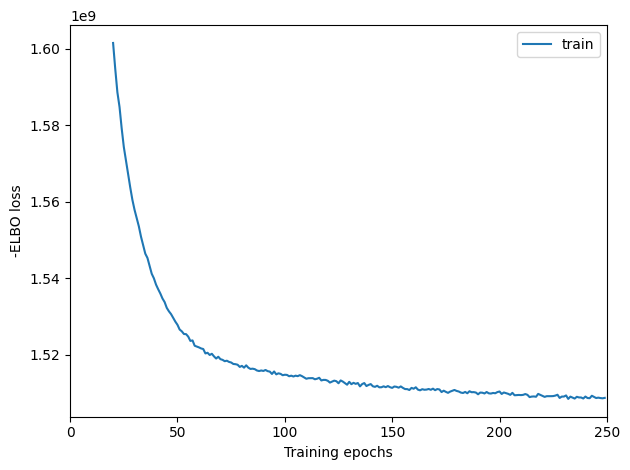

In [23]:
# plot ELBO loss history during training, removing first 20 epochs from the plot
mod.plot_history(20)

Now we train the model to estimate the reference cell type signatures. 

Note that to achieve convergence on your data (=to get stabilization of the loss) you may need to increase max_epochs=250 (See below). Also note that here we are using batch_size=2500 which is much larger than scvi-tools default and perform training on all cells in the data (train_size=1) - both parameters are defaults.

In [24]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
scrna = mod.export_posterior(scrna)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
scrna.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:09<00:00, 104.31it/s]


'../../data/visium/cell2location/reference_signatures/sc.h5ad'

In [ ]:
adata_file = f"{ref_run_name}/sc.h5ad"
scrna = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", scrna)

In [25]:
torch.cuda.empty_cache()

In [26]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in scrna.varm.keys():
    inf_aver = scrna.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in scrna.uns['mod']['factor_names']]].copy()
else:
    inf_aver = scrna.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in scrna.uns['mod']['factor_names']]].copy()
inf_aver.columns = scrna.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,Bas Inf,Bas KC,Bulge,CCR7+ DC,CD1C+ DC
A1BG,0.719908,0.042313,1.212730,2.512156,1.759796
A1BG-AS1,0.068311,0.000578,0.111481,0.126701,0.068088
A2M,0.020339,0.001578,0.127507,2.553686,0.708897
A2M-AS1,0.004405,0.001734,0.043043,0.024641,0.021837
A2ML1,0.010040,0.005060,0.001479,0.022641,0.002249
